In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import podpac
from podpac import Node

In [6]:
# COSMOS data to CSV
fn = 'tonzi'
fid = open(fn + '.txt').read()
fid2 = open(fn + '.csv', 'w')

for line in fid.split('\n'):
    l = line.split()
    a = ','.join(['T'.join(l[:2])] + l[2:]) 
    fid2.write(a + '\n')
fid2.close()

In [7]:
node = podpac.data.CSV(source=fn + '.csv', time_key=0, data_key='SOILM')
node

CSV DataSource
	source: tonzi.csv
	interpolation: nearest

C:\podpac-1.2.0\miniconda\envs\podpac\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


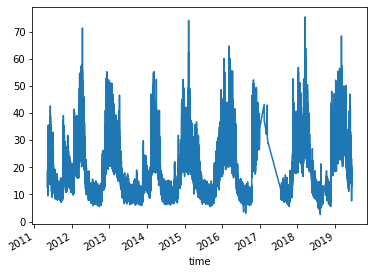

In [8]:
o = node.eval(node.native_coordinates)
o[ (o < 0) | (o > 100)] = np.nan

o.plot()

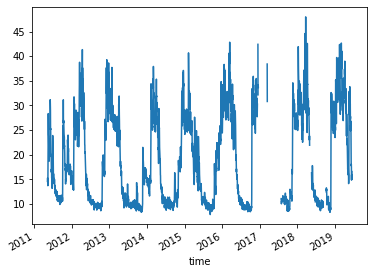

In [9]:
o2 = o.resample(time='1D').mean()
o2.plot()

In [10]:
o.time[-2]

<xarray.UnitsDataArray 'time' ()>
array('2019-06-13T14:52:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-06-13T14:52:00

In [11]:
coords = podpac.Coordinates([['2019-05-23', '2019-05-24', '2019-08-01']], dims=['time'])

In [12]:
node2 = podpac.data.Dataset(dataset=o2.to_dataset(name='data'))
node2

Dataset DataSource
	source: 
None
	interpolation: nearest

In [13]:
e1 = podpac.algorithm.ExpandCoordinates(time=['-6,Y', '0,Y', '1,Y'], source=node2, bounds_only=False)
e2 = podpac.algorithm.ExpandCoordinates(time=['-22,D', '22,D', '1,D'], source=e1, bounds_only=True)

In [14]:
# e1.get_modified_coordinates1d(podpac.Coordinates([e2.get_modified_coordinates1d(coords, 'time')]), 'time').coords

In [19]:
class SeasonalBeta(podpac.algorithm.Algorithm):
    source = podpac.NodeTrait()
    window = 45
    outputs = ['a', 'b', 'd0','d1', 'd2', 'd3', 'd4']
    levels = [0.3, 0.2, 0.1, 0.05, 0.02]
    betafit = lambda x: beta.fit(x, floc=0, fscale=1)
    def algorithm(self, inputs):
        from scipy.stats import beta
        import xarray as xr
        win = self.window // 2
        l = self.levels
        source = inputs['source']
        output = self.create_output_array(self._requested_coordinates)
        
        coords = xr.Dataset({'time': self._requested_coordinates['time'].coordinates})
        dsoy = coords.time.dt.dayofyear
        sdoy = source.time.dt.dayofyear
        
        betafit = lambda x: beta.fit(x, floc=0, fscale=100)
        for i, doy in enumerate(dsoy): 
            start = doy - win
            if start < 0: 
                start += 365

            I = sdoy >= start
            
            end = doy + win + 1
            if end > 365: 
                end -= 365
                I = I | (sdoy <= end)
            else:
                I = I & (sdoy <= end)
            if 'lat' in self._requested_coordinates.udims and 'lon' in self._requested_coordinates.udims:
                for lat in source['lat']:
                    for lon in source['lon']:
                        a, b, loc, scale = betafit(source.sel(time=I, lat=i, lon=j).dropna('time').data)
                        output.loc[dict(lat=lat, lon=lon, output='a')].iloc[dict(time=i)] = a
                        output.loc[dict(lat=lat, lon=lon, output='b')].iloc[dict(time=i)] = b
                        for ii, d in enumerate(l):
                            output['d' + str(ii)].loc[dict(lat=lat, lon=lon)].iloc[dict(time=i)] = beta.ppf(d, a, b)
            else:
                a, b, loc, scale = betafit(source.sel(time=I).dropna('time').data)
                output[dict(time=i, output=0)] = a
                output[dict(time=i, output=1)] = b
                for ii, d in enumerate(l):
                    output[dict(time=i, output=ii+2)] = beta.ppf(d, a, b)
                        
        return output
    
sb = SeasonalBeta(source=e2)
o3 = sb.eval(coords)

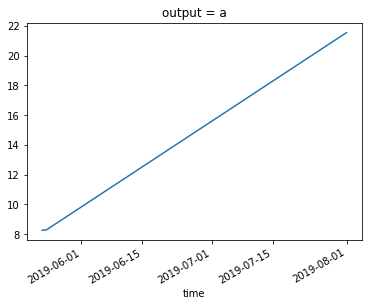

In [23]:
o3[..., 0].plot()

In [25]:
c, ci = next(coords.iterchunks((4,), True))

In [29]:
ci[0].step